# Installing libraries

In [1]:
!pip install -r https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/SafeRide_Dtection/refs/heads/main/requirements.txt

Ignoring colorama: markers 'python_version >= "3.11" and python_version < "4.0" and platform_system == "Windows"' don't match your environment
Ignoring pywin32: markers 'python_version >= "3.11" and python_version < "4.0" and sys_platform == "win32"' don't match your environment
Ignoring waitress: markers 'python_version >= "3.11" and python_version < "4.0" and platform_system == "Windows"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.6/159.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

# Uploading kaggle Auth Key

In [ ]:
from google.colab import files
files.upload()

KeyboardInterrupt: 

In [1]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Downloading dataset from Kaggle

In [2]:
!kaggle datasets download -d aslanahmedov/number-plate-detection


Dataset URL: https://www.kaggle.com/datasets/aslanahmedov/number-plate-detection
License(s): copyright-authors


In [3]:
!unzip /content/number-plate-detection.zip -d plate_data

Archive:  /content/number-plate-detection.zip
  inflating: plate_data/TEST/TEST.jpeg  
  inflating: plate_data/TEST/TEST.mp4  
  inflating: plate_data/data.yaml    
  inflating: plate_data/images/N1.jpeg  
  inflating: plate_data/images/N1.xml  
  inflating: plate_data/images/N100.jpeg  
  inflating: plate_data/images/N100.xml  
  inflating: plate_data/images/N101.jpeg  
  inflating: plate_data/images/N101.xml  
  inflating: plate_data/images/N102.jpeg  
  inflating: plate_data/images/N102.xml  
  inflating: plate_data/images/N103.jpeg  
  inflating: plate_data/images/N103.xml  
  inflating: plate_data/images/N104.jpeg  
  inflating: plate_data/images/N104.xml  
  inflating: plate_data/images/N105.jpeg  
  inflating: plate_data/images/N105.xml  
  inflating: plate_data/images/N106.jpeg  
  inflating: plate_data/images/N106.xml  
  inflating: plate_data/images/N107.jpeg  
  inflating: plate_data/images/N107.xml  
  inflating: plate_data/images/N108.jpeg  
  inflating: plate_data/images/

# Preparing dataset for training and testing

In [4]:
import os
import random
import shutil
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

# Paths
base_path = '/content/plate_data'
images_path = os.path.join(base_path, 'images')
annotations_path = os.path.join(base_path, 'images')
output_path = '/content/plate_split'  # New base folder

# Make sure output folders exist
for split in ['train', 'valid', 'test']:
    os.makedirs(os.path.join(output_path, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_path, split, 'labels'), exist_ok=True)

# Step 1: Find all images that have corresponding annotations
image_files = [f for f in os.listdir(images_path) if f.endswith('.jpeg')]
annotation_files = [f.replace('.xml', '') for f in os.listdir(annotations_path) if f.endswith('.xml')]

# Keep only images that have annotation
valid_images = [f for f in image_files if f.replace('.jpeg', '') in annotation_files]

print(f"Total valid images with annotations: {len(valid_images)}")

# Step 2: Split into train, val, test
train_imgs, temp_imgs = train_test_split(valid_images, test_size=0.3, random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.33, random_state=42)

splits = {'train': train_imgs, 'valid': val_imgs, 'test': test_imgs}

# Helper: XML to YOLO TXT converter
def convert_annotation(xml_file, txt_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    with open(txt_file, 'w') as f:
        for obj in root.findall('object'):
            cls = obj.find('name').text
            # Assuming 'helmet' is class 0, you can modify if multiple classes
            cls_id = 0
            xmlbox = obj.find('bndbox')
            xmin = int(xmlbox.find('xmin').text)
            xmax = int(xmlbox.find('xmax').text)
            ymin = int(xmlbox.find('ymin').text)
            ymax = int(xmlbox.find('ymax').text)

            # Convert to YOLO format
            x_center = (xmin + xmax) / 2 / width
            y_center = (ymin + ymax) / 2 / height
            w = (xmax - xmin) / width
            h = (ymax - ymin) / height

            f.write(f"{cls_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")

# Step 3: Move and convert
for split_name, img_list in splits.items():
    for img_file in img_list:
        img_src = os.path.join(images_path, img_file)
        img_dst = os.path.join(output_path, split_name, 'images', img_file)
        shutil.copy(img_src, img_dst)

        # Convert annotation
        xml_file = os.path.join(annotations_path, img_file.replace('.jpeg', '.xml'))
        txt_file = os.path.join(output_path, split_name, 'labels', img_file.replace('.jpeg', '.txt'))
        convert_annotation(xml_file, txt_file)

print("Dataset prepared successfully!")

Total valid images with annotations: 225
Dataset prepared successfully!


In [5]:
import os


# Folders to check
splits = ['train', 'valid', 'test']

for split in splits:
    images_dir = os.path.join(output_path, split, 'images')
    labels_dir = os.path.join(output_path, split, 'labels')

    num_images = len([f for f in os.listdir(images_dir) if f.endswith('.jpeg')])
    num_labels = len([f for f in os.listdir(labels_dir) if f.endswith('.txt')])

    print(f"{split.upper()}: {num_images} images, {num_labels} labels")


TRAIN: 157 images, 157 labels
VALID: 45 images, 45 labels
TEST: 23 images, 23 labels


# Creating YAML file for YOLO

In [6]:
dataset_yaml = """
path: ../plate_split
train: train/images
val: valid/images
test: test/images

names:
  0: Plate
"""

with open('/content/plate_split/dataset.yaml', 'w') as f:
    f.write(dataset_yaml)

print("✅ Correct dataset.yaml created!")


✅ Correct dataset.yaml created!


# Running Experiments using MLFlow

In [ ]:
# prompt: restart runtime

# This code will restart the runtime in Google Colab.
import os
os.kill(os.getpid(), 9)


In [7]:
import os
import mlflow
from ultralytics import YOLO
from itertools import product
import numpy as np

# MLflow Setup
mlflow.set_tracking_uri("file:///content/mlruns")
mlflow.set_experiment("Number Plate Detection YOLO Optimized")

# Experiment Settings
model_types = ['yolov8s.pt', 'yolov8m.pt', 'yolov8l.pt']
img_sizes = [640, 800, 960]
epochs_list = [50]

data_path = '/content/plate_split/dataset.yaml'
save_dir = '/content/yolo_runs'

# Training Loop
for model_type, imgsz, epochs in product(model_types, img_sizes, epochs_list):
    run_name = f"{model_type.replace('.pt','')}_imgsz{imgsz}_ep{epochs}"

    try:
        with mlflow.start_run(run_name=run_name):
            # Initialize model
            model = YOLO(model_type)

            # Train model
            results = model.train(
                data=data_path,
                epochs=epochs,
                imgsz=imgsz,
                save=True,
                project=save_dir,
                name=run_name,
                batch=16,
                device=0,
                workers=4,
                optimizer='AdamW',
                lr0=0.001,
                lrf=0.01,           # FINAL LR fraction (smooth decay)
                weight_decay=0.01,
                momentum=0.9,
                patience=10,        # Early stopping patience
                close_mosaic=10,
                cache=True,
                save_period=10,
                exist_ok=True,

                # Augmentations
                augment=True,
                mosaic=0.0,
                mixup=0.0,
                hsv_h=0.01,
                hsv_s=0.3,
                hsv_v=0.2,
                flipud=0.0,
                fliplr=0.1,
                degrees=5.0,
                translate=0.05,
                scale=0.1,
                shear=0.0,
                perspective=0.005,
                amp=True,
                agnostic_nms=False,
            )

            # MLflow Logging
            mlflow.log_param("model_type", model_type)
            mlflow.log_param("imgsz", imgsz)
            mlflow.log_param("epochs", epochs)
            mlflow.log_param("optimizer", "AdamW")
            mlflow.log_param("scheduler", "Linear decay using lrf=0.01")
            mlflow.log_param("augmentations", {
                "mosaic": 0.0, "mixup": 0.0, "hsv_h": 0.01, "hsv_s": 0.3, "hsv_v": 0.2,
                "flipud": 0.0, "fliplr": 0.1, "degrees": 5.0, "translate": 0.05, "scale": 0.1,
                "shear": 0.0, "perspective": 0.005
            })

            # Log Metrics
            if results:
                mlflow.log_metric("val/precision", results.box.p[0] if results.box.p is not None else 0)
                mlflow.log_metric("val/recall", results.box.r[0] if results.box.r is not None else 0)
                mlflow.log_metric("val/mAP50", results.box.map50 if results.box.map50 is not None else 0)
                mlflow.log_metric("val/mAP50-95", results.box.map if results.box.map is not None else 0)
                mlflow.log_metric("speed_inference_ms", results.speed['inference'])
                mlflow.log_metric("speed_postprocess_ms", results.speed['postprocess'])

            # Log Best Model Artifact
            best_model_path = os.path.join(save_dir, run_name, 'weights', 'best.pt')
            if os.path.exists(best_model_path):
                mlflow.log_artifact(best_model_path)

    finally:
        mlflow.end_run()

print("🎯 All experiments completed and logged to MLflow!")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


2025/04/28 16:59:27 INFO mlflow.tracking.fluent: Experiment with name 'Number Plate Detection YOLO Optimized' does not exist. Creating a new experiment.


100%|██████████| 21.5M/21.5M [00:00<00:00, 93.0MB/s]


New https://pypi.org/project/ultralytics/8.3.119 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/plate_split/dataset.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=10, cache=True, device=0, workers=4, project=/content/yolo_runs, name=yolov8s_imgsz640_ep50, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False

100%|██████████| 755k/755k [00:00<00:00, 23.0MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

Model summary: 129 layers, 11,135,987 parameters, 11,135,971 gradients, 28.6 GFLOPs

Transferred 349/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 112MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 844.2±727.3 MB/s, size: 78.6 KB)


train: Scanning /content/plate_split/train/labels... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<00:00, 2294.23it/s]

train: New cache created: /content/plate_split/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.1GB RAM): 100%|██████████| 157/157 [00:00<00:00, 176.98it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 517.6±124.4 MB/s, size: 481.8 KB)


val: Scanning /content/plate_split/valid/labels... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<00:00, 2250.00it/s]

val: New cache created: /content/plate_split/valid/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 45/45 [00:01<00:00, 23.22it/s]


Plotting labels to /content/yolo_runs/yolov8s_imgsz640_ep50/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.01), 63 bias(decay=0.0)


2025/04/28 16:59:44 INFO mlflow.tracking.fluent: Experiment with name '/content/yolo_runs' does not exist. Creating a new experiment.
2025/04/28 16:59:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/04/28 16:59:47 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/04/28 16:59:47 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/04/28 16:59:47 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(8fce096f53834a58ae089f9bfaffbee7) to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/yolo_runs/yolov8s_imgsz640_ep50
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.59G      1.917      12.41      1.846         13        640: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

                   all         45         45      0.138      0.289      0.119     0.0668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.21G      1.629      2.565      1.583         12        640: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

                   all         45         45       0.72      0.667      0.635      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.24G      1.455      1.385      1.398         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

                   all         45         45      0.794      0.778      0.784      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.28G      1.415      1.336      1.395         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         45         45      0.743      0.711      0.755      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.32G      1.392      1.306      1.385         12        640: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

                   all         45         45      0.896      0.769      0.859      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.36G      1.373      1.174        1.4         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.62it/s]

                   all         45         45      0.501      0.844      0.561      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.39G      1.547       1.34      1.468         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]

                   all         45         45       0.79        0.8      0.849      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.43G      1.452      1.247      1.403         13        640: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         45         45      0.856      0.867      0.921      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.46G      1.403      1.133      1.366         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]

                   all         45         45       0.73      0.733      0.822      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       4.5G      1.343      1.155      1.408         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

                   all         45         45      0.785      0.778      0.779      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.54G      1.444      1.169      1.452         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

                   all         45         45      0.739      0.754      0.774      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.57G      1.421      1.232      1.425         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]

                   all         45         45      0.816      0.778      0.846      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.61G       1.39      1.118      1.312         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         45         45      0.878      0.797       0.84      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.65G      1.339      1.165      1.322         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

                   all         45         45      0.891      0.911      0.964      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.68G      1.268       1.09      1.373         13        640: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         45         45      0.818      0.896      0.903      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.72G      1.305      1.055      1.317         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]

                   all         45         45      0.836      0.794      0.894      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.75G      1.343      1.126      1.428         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.67it/s]

                   all         45         45      0.901      0.844      0.947      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.79G      1.399      1.022      1.405         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         45         45      0.965      0.778      0.881      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.83G      1.333     0.9899      1.335         13        640: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         45         45       0.86      0.844      0.894      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.86G      1.244     0.9264      1.264         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

                   all         45         45      0.787        0.8      0.852      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       4.9G       1.26      1.056      1.346         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.58it/s]

                   all         45         45      0.906      0.858       0.89      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.94G      1.129     0.9485      1.203         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         45         45      0.827       0.85      0.916      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.97G      1.169     0.9565      1.279         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.37it/s]

                   all         45         45      0.908      0.822      0.892       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.01G      1.154     0.9211      1.228         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.76it/s]

                   all         45         45      0.869      0.883      0.906      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.04G      1.211     0.8649      1.282         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.47it/s]

                   all         45         45      0.914      0.945      0.943       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.33G      1.173     0.9437      1.242         13        640: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

                   all         45         45      0.906      0.859      0.896      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.37G      1.224     0.9703      1.272         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

                   all         45         45      0.849      0.933      0.959      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       5.4G      1.205     0.9162      1.247         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.90it/s]

                   all         45         45      0.855      0.956       0.95      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.44G      1.229       0.94       1.28         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         45         45      0.878      0.889      0.926      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.47G      1.105     0.8487      1.204         12        640: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]

                   all         45         45      0.949      0.911      0.984      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.51G      1.173     0.8197      1.255         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.63it/s]

                   all         45         45      0.976      0.901      0.942      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.55G      1.138      0.816      1.255         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

                   all         45         45      0.882      0.844      0.862      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.58G      1.205     0.8191      1.222         13        640: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]

                   all         45         45      0.906      0.867       0.87      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.62G      1.181     0.8221      1.274         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.66it/s]

                   all         45         45      0.932       0.91      0.941       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.66G      1.161     0.8065      1.249         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         45         45      0.845      0.889      0.859      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.69G      1.075     0.7585      1.181         13        640: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]

                   all         45         45      0.919      0.889      0.932      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.73G      1.044     0.8177      1.191         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.49it/s]

                   all         45         45      0.946      0.911      0.962      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.77G      1.027      0.732       1.18         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.49it/s]

                   all         45         45      0.953      0.898      0.965      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.84G       1.03     0.7468       1.18         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]

                   all         45         45      0.948      0.911      0.967      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.87G      1.011     0.7213      1.128         12        640: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.45it/s]

                   all         45         45      0.927      0.889      0.923       0.52
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 30, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



40 epochs completed in 0.042 hours.
Optimizer stripped from /content/yolo_runs/yolov8s_imgsz640_ep50/weights/last.pt, 22.5MB
Optimizer stripped from /content/yolo_runs/yolov8s_imgsz640_ep50/weights/best.pt, 22.5MB

Validating /content/yolo_runs/yolov8s_imgsz640_ep50/weights/best.pt...
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


                   all         45         45      0.918      0.999      0.983       0.56
Speed: 0.2ms preprocess, 24.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/yolo_runs/yolov8s_imgsz640_ep50
MLflow: results logged to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
New https://pypi.org/project/ultralytics/8.3.119 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/plate_split/dataset.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=800, save=True, save_period=10, cache=True, device=0, workers=4, project=/content/yolo_runs, name=yolov8s_imgsz800_ep50, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=Non

train: Scanning /content/plate_split/train/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (0.2GB RAM): 100%|██████████| 157/157 [00:01<00:00, 110.23it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 459.4±266.6 MB/s, size: 481.8 KB)


val: Scanning /content/plate_split/valid/labels.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 45/45 [00:00<00:00, 45.47it/s]


Plotting labels to /content/yolo_runs/yolov8s_imgsz800_ep50/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.01), 63 bias(decay=0.0)


2025/04/28 17:02:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/04/28 17:02:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/04/28 17:02:32 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/04/28 17:02:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(e4715dba894242acb30062d6b56c0930) to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 800 train, 800 val
Using 2 dataloader workers
Logging results to /content/yolo_runs/yolov8s_imgsz800_ep50
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.84G      2.137      19.42      2.152         13        800: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         45         45      0.179      0.133     0.0792     0.0299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.73G      1.702      2.989      1.784         13        800: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.16it/s]

                   all         45         45      0.547      0.444      0.451      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.73G      1.675       1.73      1.824         12        800: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]

                   all         45         45      0.626        0.6      0.595      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.73G      1.653      1.681      1.787         13        800: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

                   all         45         45      0.344      0.289      0.206     0.0444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.73G      1.549      1.665      1.641         12        800: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.25it/s]

                   all         45         45      0.548      0.711      0.651      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.73G      1.463      1.497      1.575         12        800: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         45         45        0.7      0.779      0.794      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.73G      1.425      1.494      1.559         13        800: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]

                   all         45         45      0.741      0.822      0.797      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.73G      1.542      1.473      1.701         13        800: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.22it/s]

                   all         45         45      0.779        0.8      0.785      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.73G      1.539      1.425      1.718         13        800: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         45         45      0.631      0.622       0.65      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.73G      1.539      1.536      1.665         13        800: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

                   all         45         45      0.888      0.882      0.884      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.73G      1.479      1.449      1.635         13        800: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         45         45      0.649        0.8      0.744       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.73G      1.465      1.574      1.663         13        800: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.17it/s]

                   all         45         45      0.801      0.533       0.64      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.73G      1.563      1.409      1.588         13        800: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

                   all         45         45       0.84      0.817      0.834      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.73G      1.472      1.367      1.595         13        800: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]

                   all         45         45      0.915      0.756      0.877      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.73G      1.408      1.354      1.594         13        800: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

                   all         45         45      0.945      0.766      0.865      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.73G      1.499      1.352      1.594         13        800: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         45         45      0.873      0.933      0.935       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.73G      1.403      1.412      1.673         12        800: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         45         45      0.892      0.922      0.943      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.73G      1.408       1.28      1.553         13        800: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]


                   all         45         45      0.946      0.889      0.942      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.73G      1.341      1.263       1.53         13        800: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]

                   all         45         45      0.898      0.911      0.928      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.73G      1.315      1.163      1.505         13        800: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.32it/s]

                   all         45         45      0.871      0.889      0.923      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.73G      1.311      1.257      1.513         13        800: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         45         45      0.888      0.881      0.926      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.73G       1.38      1.174      1.523         12        800: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]

                   all         45         45      0.953      0.911      0.973      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.73G      1.311       1.26      1.523         13        800: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

                   all         45         45      0.915      0.911      0.968      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.73G      1.308      1.229      1.514         13        800: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.42it/s]

                   all         45         45      0.901      0.844      0.939      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.73G      1.284      1.151      1.452         13        800: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

                   all         45         45      0.904       0.84      0.946      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.73G      1.268       1.19      1.476         13        800: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         45         45      0.874      0.925      0.936      0.484
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 16, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



26 epochs completed in 0.039 hours.
Optimizer stripped from /content/yolo_runs/yolov8s_imgsz800_ep50/weights/last.pt, 22.5MB
Optimizer stripped from /content/yolo_runs/yolov8s_imgsz800_ep50/weights/best.pt, 22.5MB

Validating /content/yolo_runs/yolov8s_imgsz800_ep50/weights/best.pt...
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


                   all         45         45       0.89      0.889       0.96      0.555
Speed: 0.3ms preprocess, 22.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /content/yolo_runs/yolov8s_imgsz800_ep50
MLflow: results logged to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
New https://pypi.org/project/ultralytics/8.3.119 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/plate_split/dataset.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=960, save=True, save_period=10, cache=True, device=0, workers=4, project=/content/yolo_runs, name=yolov8s_imgsz960_ep50, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=Non

train: Scanning /content/plate_split/train/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (0.3GB RAM): 100%|██████████| 157/157 [00:01<00:00, 122.60it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.1±0.2 ms, read: 484.8±242.8 MB/s, size: 481.8 KB)


val: Scanning /content/plate_split/valid/labels.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 45/45 [00:01<00:00, 32.35it/s]


Plotting labels to /content/yolo_runs/yolov8s_imgsz960_ep50/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.01), 63 bias(decay=0.0)


2025/04/28 17:05:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/04/28 17:05:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/04/28 17:05:09 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/04/28 17:05:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(147589f8e6014f6cb37266a95f3f6960) to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 960 train, 960 val
Using 2 dataloader workers
Logging results to /content/yolo_runs/yolov8s_imgsz960_ep50
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      8.12G      2.269      27.39      2.365         13        960: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         45         45     0.0189      0.111    0.00673    0.00242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.95G      2.027      9.759      2.173         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         45         45      0.379      0.511      0.515      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.01G      1.743       1.99      1.861         13        960: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         45         45      0.735      0.711      0.735      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.99G      1.817      1.978      1.967         13        960: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         45         45      0.761      0.689      0.724      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         8G      1.723      1.808      1.833         12        960: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         45         45       0.42      0.693        0.5      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         8G      1.728       1.74      1.837         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all         45         45      0.488      0.578      0.495       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.96G      1.662      1.775      1.762         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         45         45      0.541      0.911      0.853      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.01G      1.677      1.696      1.832         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         45         45      0.871        0.6      0.777      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.96G      1.699      1.627      1.807         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all         45         45      0.777      0.774      0.821      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.98G      1.673      1.792        1.9         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


                   all         45         45      0.866       0.72      0.855      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.96G      1.675      1.629      1.807         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         45         45       0.51        0.8      0.613      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.96G      1.623      1.713      1.887         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         45         45      0.722      0.711      0.745      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.96G      1.665      1.561      1.812         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all         45         45      0.565        0.6      0.636      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.96G      1.661      1.675      1.786         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


                   all         45         45      0.864      0.707      0.803      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.96G       1.62       1.58      1.798         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all         45         45      0.884      0.756       0.87      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.97G      1.603      1.541      1.776         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         45         45      0.824      0.733       0.77      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.96G      1.559      1.542      1.758         12        960: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         45         45      0.839      0.733      0.809      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.97G      1.556      1.524      1.731         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         45         45      0.872        0.8      0.841      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.96G      1.564      1.576      1.811         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         45         45      0.658      0.711      0.708      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.97G        1.5        1.4      1.713         13        960: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all         45         45       0.95      0.644      0.814      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.96G      1.437      1.519      1.706         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         45         45      0.845      0.756       0.86      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.97G      1.426      1.423       1.59         12        960: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

                   all         45         45      0.961      0.844      0.934      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.96G      1.431      1.482      1.636         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


                   all         45         45      0.836      0.867      0.885      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.97G      1.437      1.404      1.645         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         45         45      0.887      0.933      0.949      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.96G       1.44      1.423      1.652         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         45         45       0.92      0.867      0.924      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.96G      1.449      1.473      1.644         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         45         45       0.93      0.888      0.933      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.96G       1.43      1.391      1.652         12        960: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all         45         45      0.844      0.842      0.862      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.97G      1.362      1.312      1.598         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         45         45       0.91      0.778      0.906      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.96G      1.427      1.322      1.654         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

                   all         45         45      0.829      0.778      0.862      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.97G      1.386      1.343      1.627         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         45         45      0.929      0.889      0.942      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.96G      1.338      1.259      1.587         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


                   all         45         45      0.907      0.933      0.926      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.98G       1.31      1.304      1.501         12        960: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         45         45      0.904      0.841      0.881      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.96G       1.38      1.253      1.514         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         45         45      0.902      0.822      0.878      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.97G      1.313      1.255      1.561         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all         45         45      0.886      0.867      0.882      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.96G      1.272       1.29      1.554         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         45         45      0.882      0.822      0.876      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.98G      1.272      1.184      1.551         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         45         45      0.908      0.881      0.927      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.96G      1.325      1.275      1.662         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         45         45      0.883      0.844       0.95       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.97G      1.315      1.137      1.575         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]


                   all         45         45      0.879      0.911      0.933      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.96G      1.293      1.149      1.536         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         45         45      0.892      0.918       0.93      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.97G      1.254      1.157      1.501         13        960: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


                   all         45         45      0.894      0.941       0.96      0.506
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 30, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

40 epochs completed in 0.084 hours.
Optimizer stripped from /content/yolo_runs/yolov8s_imgsz960_ep50/weights/last.pt, 22.6MB
Optimizer stripped from /content/yolo_runs/yolov8s_imgsz960_ep50/weights/best.pt, 22.6MB

Validating /content/yolo_runs/yolov8s_imgsz960_ep50/weights/best.pt...
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


                   all         45         45      0.934      0.945      0.974      0.549
Speed: 0.5ms preprocess, 22.8ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /content/yolo_runs/yolov8s_imgsz960_ep50
MLflow: results logged to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'


100%|██████████| 49.7M/49.7M [00:00<00:00, 370MB/s]


New https://pypi.org/project/ultralytics/8.3.119 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/plate_split/dataset.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=10, cache=True, device=0, workers=4, project=/content/yolo_runs, name=yolov8m_imgsz640_ep50, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False

train: Scanning /content/plate_split/train/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (0.1GB RAM): 100%|██████████| 157/157 [00:00<00:00, 199.00it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.1 ms, read: 559.0±148.1 MB/s, size: 481.8 KB)


val: Scanning /content/plate_split/valid/labels.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 45/45 [00:00<00:00, 70.25it/s]


Plotting labels to /content/yolo_runs/yolov8m_imgsz640_ep50/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.01), 83 bias(decay=0.0)


2025/04/28 17:10:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/04/28 17:10:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/04/28 17:10:28 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/04/28 17:10:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(9fa260ec13b74d9b9d3da62a29d91b3a) to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/yolo_runs/yolov8m_imgsz640_ep50
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.33G      1.743      4.703      1.859         13        640: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         45         45      0.893      0.533      0.709       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.22G      1.657      2.026      1.575         12        640: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         45         45       0.96      0.644      0.773      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.29G       1.48      1.629      1.514         13        640: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         45         45      0.602      0.739      0.714      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.36G      1.512       1.52      1.527         13        640: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         45         45      0.356      0.533        0.3      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.36G      1.483      1.393      1.523         12        640: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         45         45      0.684      0.733      0.657      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.36G      1.442      1.556      1.536         13        640: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         45         45      0.524      0.756       0.64      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.36G      1.515      1.361      1.559         13        640: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         45         45      0.748      0.822      0.819      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.36G      1.482      1.457       1.62         13        640: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         45         45      0.737      0.822      0.836      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.36G      1.544      1.401      1.659         13        640: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         45         45      0.864      0.422        0.8      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.36G      1.548      1.484      1.648         13        640: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         45         45      0.481      0.778      0.605      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.36G      1.505      1.267       1.61         13        640: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         45         45      0.317      0.756      0.279      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.36G      1.414      1.297      1.542         13        640: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         45         45      0.798        0.6      0.697      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.36G       1.52      1.243      1.563         13        640: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         45         45      0.654      0.578      0.567      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.48G      1.452      1.173      1.525         13        640: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         45         45      0.833      0.889      0.905        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.34G      1.483      1.253      1.556         13        640: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         45         45      0.719      0.689      0.748      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.34G      1.398      1.125      1.519         13        640: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         45         45      0.744      0.777      0.816      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.34G      1.421      1.194      1.574         13        640: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         45         45      0.851      0.762      0.827      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.41G      1.432      1.208      1.523         13        640: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         45         45      0.888      0.708      0.838      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.27G      1.398        1.1      1.494         13        640: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         45         45      0.862      0.693       0.81      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.32G      1.418      1.223      1.505         13        640: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         45         45      0.834      0.671      0.758      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.32G        1.3      1.207      1.462         13        640: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         45         45      0.795       0.69      0.749      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.39G      1.243      1.155      1.374         13        640: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         45         45      0.862      0.822      0.894      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       6.4G      1.245      1.087      1.401         13        640: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         45         45      0.901      0.813      0.865      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.27G      1.261      1.026      1.373         13        640: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         45         45      0.893      0.867       0.91      0.438
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 14, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



24 epochs completed in 0.058 hours.
Optimizer stripped from /content/yolo_runs/yolov8m_imgsz640_ep50/weights/last.pt, 52.0MB
Optimizer stripped from /content/yolo_runs/yolov8m_imgsz640_ep50/weights/best.pt, 52.0MB

Validating /content/yolo_runs/yolov8m_imgsz640_ep50/weights/best.pt...
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


                   all         45         45      0.826      0.867      0.922      0.526
Speed: 0.2ms preprocess, 40.7ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /content/yolo_runs/yolov8m_imgsz640_ep50
MLflow: results logged to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
New https://pypi.org/project/ultralytics/8.3.119 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/plate_split/dataset.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=800, save=True, save_period=10, cache=True, device=0, workers=4, project=/content/yolo_runs, name=yolov8m_imgsz800_ep50, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=Non

train: Scanning /content/plate_split/train/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (0.2GB RAM): 100%|██████████| 157/157 [00:01<00:00, 152.01it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.1±0.0 ms, read: 230.6±103.7 MB/s, size: 481.8 KB)


val: Scanning /content/plate_split/valid/labels.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 45/45 [00:00<00:00, 53.21it/s]


Plotting labels to /content/yolo_runs/yolov8m_imgsz800_ep50/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.01), 83 bias(decay=0.0)


2025/04/28 17:14:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/04/28 17:14:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/04/28 17:14:27 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/04/28 17:14:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(2fa62e0a5824455f90b08d0e843d4115) to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 800 train, 800 val
Using 2 dataloader workers
Logging results to /content/yolo_runs/yolov8m_imgsz800_ep50
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      10.1G      1.896      5.219       2.04         13        800: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         45         45      0.701      0.261      0.451       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      9.92G        1.7      2.034      1.773         13        800: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         45         45       0.86      0.547      0.609      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50        10G      1.728      1.878      1.916         12        800: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         45         45      0.695      0.733      0.718       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50        10G      1.679      2.142      1.828         13        800: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         45         45      0.531        0.4      0.413      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50        10G       1.57      1.609      1.797         12        800: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         45         45      0.142      0.667      0.314      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50        10G      1.509      1.488      1.714         12        800: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         45         45      0.156      0.467      0.142     0.0686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.92G      1.572      1.782      1.762         13        800: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         45         45      0.319      0.333      0.299      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50        10G      1.535      1.693      1.797         13        800: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         45         45      0.327      0.867      0.447       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      9.96G      1.623      1.736      1.852         13        800: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         45         45      0.332      0.467      0.449      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.96G      1.669       1.59       1.89         13        800: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         45         45     0.0676      0.444      0.045     0.0162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.92G      1.608      1.563      1.834         13        800: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]

                   all         45         45      0.215      0.311       0.17     0.0617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.97G       1.64      1.574      1.935         13        800: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         45         45     0.0311      0.222     0.0151    0.00514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.91G      1.597      1.448      1.779         13        800: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         45         45     0.0395      0.578     0.0317     0.0128
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 3, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



13 epochs completed in 0.055 hours.
Optimizer stripped from /content/yolo_runs/yolov8m_imgsz800_ep50/weights/last.pt, 52.1MB
Optimizer stripped from /content/yolo_runs/yolov8m_imgsz800_ep50/weights/best.pt, 52.1MB

Validating /content/yolo_runs/yolov8m_imgsz800_ep50/weights/best.pt...
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


                   all         45         45      0.743      0.822      0.876      0.347
Speed: 0.4ms preprocess, 36.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /content/yolo_runs/yolov8m_imgsz800_ep50
MLflow: results logged to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
New https://pypi.org/project/ultralytics/8.3.119 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/plate_split/dataset.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=960, save=True, save_period=10, cache=True, device=0, workers=4, project=/content/yolo_runs, name=yolov8m_imgsz960_ep50, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=Non

train: Scanning /content/plate_split/train/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (0.3GB RAM): 100%|██████████| 157/157 [00:01<00:00, 117.02it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 441.8±99.7 MB/s, size: 481.8 KB)


val: Scanning /content/plate_split/valid/labels.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 45/45 [00:01<00:00, 38.33it/s]


Plotting labels to /content/yolo_runs/yolov8m_imgsz960_ep50/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.01), 83 bias(decay=0.0)


2025/04/28 17:18:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/04/28 17:18:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/04/28 17:18:11 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/04/28 17:18:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(613b7b37237d477586a9f21427c0b65d) to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 960 train, 960 val
Using 2 dataloader workers
Logging results to /content/yolo_runs/yolov8m_imgsz960_ep50
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      14.1G      1.926      6.518      2.154         13        960: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         45         45      0.206     0.0985     0.0764      0.041



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      14.4G      1.911      2.005      1.994         13        960: 100%|██████████| 10/10 [00:12<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         45         45      0.221      0.178      0.103      0.032



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50        14G      1.633      2.798      1.893         13        960: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all         45         45      0.695      0.667      0.616      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50        14G      1.813      2.043      1.915         13        960: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         45         45       0.18      0.533      0.206      0.059



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50        14G       1.75      2.003      1.873         12        960: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         45         45      0.115      0.333      0.126     0.0321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50        14G      1.858      1.872      1.978         13        960: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         45         45     0.0745      0.422      0.107     0.0413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      13.8G      1.814      2.254      2.006         13        960: 100%|██████████| 10/10 [00:12<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         45         45      0.083      0.733      0.126     0.0601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      14.1G       1.95       2.39      2.215         13        960: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         45         45     0.0289      0.644     0.0257    0.00749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      13.9G      1.911      1.965      2.035         13        960: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         45         45      0.145      0.756      0.138     0.0444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50        14G       1.74      2.033       2.07         13        960: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         45         45      0.112      0.244     0.0485    0.00941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      13.8G      1.799      1.977      1.988         13        960: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         45         45      0.106      0.289      0.101     0.0242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50        14G      1.847       2.11       2.09         13        960: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         45         45      0.212      0.467      0.293     0.0945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      13.8G      1.831      1.841      2.035         13        960: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         45         45      0.345      0.317       0.27     0.0794
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 3, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



13 epochs completed in 0.067 hours.
Optimizer stripped from /content/yolo_runs/yolov8m_imgsz960_ep50/weights/last.pt, 52.1MB
Optimizer stripped from /content/yolo_runs/yolov8m_imgsz960_ep50/weights/best.pt, 52.1MB

Validating /content/yolo_runs/yolov8m_imgsz960_ep50/weights/best.pt...
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


                   all         45         45      0.642      0.667      0.675       0.21
Speed: 0.4ms preprocess, 49.5ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /content/yolo_runs/yolov8m_imgsz960_ep50
MLflow: results logged to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'


100%|██████████| 83.7M/83.7M [00:03<00:00, 28.0MB/s]


New https://pypi.org/project/ultralytics/8.3.119 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/plate_split/dataset.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=10, cache=True, device=0, workers=4, project=/content/yolo_runs, name=yolov8l_imgsz640_ep50, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False

train: Scanning /content/plate_split/train/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (0.1GB RAM): 100%|██████████| 157/157 [00:01<00:00, 137.61it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 69.8±63.5 MB/s, size: 481.8 KB)


val: Scanning /content/plate_split/valid/labels.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 45/45 [00:00<00:00, 97.49it/s]


Plotting labels to /content/yolo_runs/yolov8l_imgsz640_ep50/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.01), 103 bias(decay=0.0)


2025/04/28 17:22:40 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/04/28 17:22:40 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/04/28 17:22:40 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/04/28 17:22:40 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(7cc75cd432d2473ea5200c246c2e2b31) to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/yolo_runs/yolov8l_imgsz640_ep50
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.61G      1.819      5.213      2.042         13        640: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         45         45      0.011      0.222     0.0204     0.0107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       9.4G      1.754      2.209      1.723         12        640: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         45         45      0.589      0.644       0.45      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      9.67G      1.623      1.837      1.704         13        640: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         45         45      0.355      0.556      0.395      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      9.67G      1.709      1.846      1.823         13        640: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         45         45    0.00299      0.244     0.0012   0.000458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      9.69G       1.67      1.929      1.697         12        640: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         45         45     0.0124      0.533     0.0107    0.00378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      9.67G      1.598       1.58      1.695         13        640: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         45         45     0.0181      0.578     0.0236    0.00961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.49G      1.722      1.822      1.777         13        640: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all         45         45     0.0246      0.133    0.00782    0.00333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      9.59G      1.726      2.919      1.907         13        640: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         45         45     0.0154      0.222     0.0142    0.00548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      9.66G      1.725      1.945      1.809         13        640: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         45         45     0.0162        0.8     0.0176    0.00763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.64G      1.723      1.748      1.815         13        640: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         45         45     0.0902      0.756     0.0931     0.0388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.49G      1.742      1.653      1.776         13        640: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]

                   all         45         45       0.19        0.6      0.192     0.0862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.65G       1.67      1.656      1.733         13        640: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all         45         45     0.0312      0.356     0.0167    0.00597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.49G      1.711      1.522      1.681         13        640: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all         45         45     0.0734      0.111     0.0367     0.0223
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 3, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



13 epochs completed in 0.081 hours.
Optimizer stripped from /content/yolo_runs/yolov8l_imgsz640_ep50/weights/last.pt, 87.6MB
Optimizer stripped from /content/yolo_runs/yolov8l_imgsz640_ep50/weights/best.pt, 87.6MB

Validating /content/yolo_runs/yolov8l_imgsz640_ep50/weights/best.pt...
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


                   all         45         45      0.622      0.511      0.528      0.227
Speed: 0.2ms preprocess, 43.6ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /content/yolo_runs/yolov8l_imgsz640_ep50
MLflow: results logged to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
New https://pypi.org/project/ultralytics/8.3.119 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/plate_split/dataset.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=800, save=True, save_period=10, cache=True, device=0, workers=4, project=/content/yolo_runs, name=yolov8l_imgsz800_ep50, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=Non

train: Scanning /content/plate_split/train/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.2GB RAM): 100%|██████████| 157/157 [00:01<00:00, 99.74it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 453.5±71.5 MB/s, size: 481.8 KB)


val: Scanning /content/plate_split/valid/labels.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 45/45 [00:00<00:00, 47.26it/s]


Plotting labels to /content/yolo_runs/yolov8l_imgsz800_ep50/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.01), 103 bias(decay=0.0)


2025/04/28 17:28:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/04/28 17:28:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/04/28 17:28:20 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/04/28 17:28:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(0d17dc91d8a043bcb6641b1bd2e17fb2) to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 800 train, 800 val
Using 2 dataloader workers
Logging results to /content/yolo_runs/yolov8l_imgsz800_ep50
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      14.3G      1.931      5.788      2.216         13        800: 100%|██████████| 10/10 [00:13<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         45         45    0.00015     0.0444   7.99e-05   7.99e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      14.3G      1.781      3.289        1.9         13        800: 100%|██████████| 10/10 [00:13<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         45         45       0.82      0.267      0.332      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      12.2G      1.827      2.956       1.99         12        800: 100%|██████████| 10/10 [00:13<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         45         45      0.274     0.0889     0.0493      0.031



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50        12G      1.857      2.905      2.045         13        800: 100%|██████████| 10/10 [00:13<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         45         45     0.0199     0.0667     0.0308     0.0197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50        12G      1.982      2.702      2.106         12        800: 100%|██████████| 10/10 [00:13<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         45         45     0.0617      0.422     0.0576      0.022



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      12.5G      2.015      2.299      2.282         12        800: 100%|██████████| 10/10 [00:12<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         45         45    0.00213      0.356    0.00163   0.000687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      11.9G      2.134      2.616      2.237         13        800: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         45         45          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      12.2G      1.893      2.429      2.245         13        800: 100%|██████████| 10/10 [00:13<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all         45         45          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      12.1G      1.963      2.291      2.193         13        800: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         45         45   0.000298     0.0889   0.000168   6.02e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      12.2G      1.958      2.224      2.238         13        800: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         45         45    0.00207      0.533     0.0017   0.000459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      12.1G      2.139      2.621       2.35         13        800: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         45         45     0.0286      0.667     0.0299     0.0113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      12.1G      2.085      2.379       2.36         13        800: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         45         45     0.0013      0.178   0.000571   0.000181
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 2, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



12 epochs completed in 0.100 hours.
Optimizer stripped from /content/yolo_runs/yolov8l_imgsz800_ep50/weights/last.pt, 87.7MB
Optimizer stripped from /content/yolo_runs/yolov8l_imgsz800_ep50/weights/best.pt, 87.7MB

Validating /content/yolo_runs/yolov8l_imgsz800_ep50/weights/best.pt...
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


                   all         45         45      0.564      0.422      0.422      0.114
Speed: 0.3ms preprocess, 54.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /content/yolo_runs/yolov8l_imgsz800_ep50
MLflow: results logged to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
New https://pypi.org/project/ultralytics/8.3.119 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/plate_split/dataset.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=960, save=True, save_period=10, cache=True, device=0, workers=4, project=/content/yolo_runs, name=yolov8l_imgsz960_ep50, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=Non

train: Scanning /content/plate_split/train/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.3GB RAM): 100%|██████████| 157/157 [00:01<00:00, 117.12it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 43.6±41.5 MB/s, size: 481.8 KB)


val: Scanning /content/plate_split/valid/labels.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 45/45 [00:01<00:00, 44.67it/s]


Plotting labels to /content/yolo_runs/yolov8l_imgsz960_ep50/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.01), 103 bias(decay=0.0)


2025/04/28 17:35:08 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/04/28 17:35:08 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/04/28 17:35:08 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/04/28 17:35:08 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(1ffad5dbe8e04bceb0c9d1ddf69663b9) to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 960 train, 960 val
Using 2 dataloader workers
Logging results to /content/yolo_runs/yolov8l_imgsz960_ep50
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/10 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 676.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 336.12 MiB is free. Process 21568 has 14.41 GiB memory in use. Of the allocated memory 14.03 GiB is allocated by PyTorch, and 224.26 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Appending prev results and continuing experiments

In [1]:
# ------------------ Imports ------------------
import os
import mlflow
from ultralytics import YOLO
from itertools import product

# ------------------ MLflow Setup ------------------
mlflow.set_tracking_uri("file:///content/mlruns")
mlflow.set_experiment("Number Plate Detection YOLO Optimized")

# ------------------ Experiment Settings ------------------
model_types = ['yolov8s.pt', 'yolov8m.pt', 'yolov8l.pt']
img_sizes = [640, 800, 960]
epochs_list = [50]

data_path = '/content/plate_split/dataset.yaml'
save_dir = '/content/yolo_runs'

# ------------------ Training Loop ------------------
for model_type, imgsz, epochs in product(model_types, img_sizes, epochs_list):

    run_name = f"{model_type.replace('.pt', '')}_imgsz{imgsz}_ep{epochs}"
    model_output_dir = os.path.join(save_dir, run_name)
    best_model_path = os.path.join(model_output_dir, 'weights', 'best.pt')

    # 🛑 Skip training if already done
    if os.path.exists(best_model_path):
        print(f"✅ Skipping {run_name} (already trained).")
        continue
    else:
        print(f"🚀 Starting training for {run_name}...")

    # 🔥 Dynamic Batch Size (smaller if imgsz=960)
    batch_size = 16 if imgsz <= 800 else 8

    try:
        with mlflow.start_run(run_name=run_name):
            # Initialize model
            model = YOLO(model_type)

            # Train
            results = model.train(
                data=data_path,
                epochs=epochs,
                imgsz=imgsz,
                batch=batch_size,
                device=0,
                workers=4,
                optimizer='AdamW',
                lr0=0.001,
                lrf=0.01,
                weight_decay=0.01,
                momentum=0.9,
                patience=10,
                close_mosaic=10,
                cache=True,
                save=True,
                save_period=10,
                project=save_dir,
                name=run_name,
                exist_ok=True,

                augment=True,
                mosaic=0.0,
                mixup=0.0,
                hsv_h=0.01,
                hsv_s=0.3,
                hsv_v=0.2,
                flipud=0.0,
                fliplr=0.1,
                degrees=5.0,
                translate=0.05,
                scale=0.1,
                shear=0.0,
                perspective=0.005,
                amp=True,
                agnostic_nms=False,
            )

            # Log Parameters
            mlflow.log_param("model_type", model_type)
            mlflow.log_param("imgsz", imgsz)
            mlflow.log_param("epochs", epochs)
            mlflow.log_param("batch_size", batch_size)
            mlflow.log_param("optimizer", "AdamW")
            mlflow.log_param("lrf", 0.01)

            # Log Metrics
            if results:
                mlflow.log_metric("val/precision", results.box.p[0] if results.box.p else 0)
                mlflow.log_metric("val/recall", results.box.r[0] if results.box.r else 0)
                mlflow.log_metric("val/mAP50", results.box.map50)
                mlflow.log_metric("val/mAP50-95", results.box.map)
                mlflow.log_metric("speed_inference_ms", results.speed['inference'])
                mlflow.log_metric("speed_postprocess_ms", results.speed['postprocess'])

            # Save Best Model
            if os.path.exists(best_model_path):
                mlflow.log_artifact(best_model_path)

    finally:
        mlflow.end_run()

print("🏁 All remaining experiments completed and logged!")


✅ Skipping yolov8s_imgsz640_ep50 (already trained).
✅ Skipping yolov8s_imgsz800_ep50 (already trained).
✅ Skipping yolov8s_imgsz960_ep50 (already trained).
✅ Skipping yolov8m_imgsz640_ep50 (already trained).
✅ Skipping yolov8m_imgsz800_ep50 (already trained).
✅ Skipping yolov8m_imgsz960_ep50 (already trained).
✅ Skipping yolov8l_imgsz640_ep50 (already trained).
✅ Skipping yolov8l_imgsz800_ep50 (already trained).
🚀 Starting training for yolov8l_imgsz960_ep50...
New https://pypi.org/project/ultralytics/8.3.119 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/plate_split/dataset.yaml, epochs=50, time=None, patience=10, batch=8, imgsz=960, save=True, save_period=10, cache=True, device=0, workers=4, project=/content/yolo_runs, name=yolov8l_imgsz960_ep50, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=0, determini

train: Scanning /content/plate_split/train/labels.cache... 157 images, 0 backgrounds, 0 corrupt: 100%|██████████| 157/157 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (0.3GB RAM): 100%|██████████| 157/157 [00:00<00:00, 162.56it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 835.5±338.5 MB/s, size: 481.8 KB)


val: Scanning /content/plate_split/valid/labels.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 45/45 [00:00<00:00, 55.73it/s]


Plotting labels to /content/yolo_runs/yolov8l_imgsz960_ep50/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.01), 103 bias(decay=0.0)


2025/04/28 17:48:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/04/28 17:48:57 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/04/28 17:48:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(51e2c0e11e8f40ea9a937fa7ea42f1b1) to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 960 train, 960 val
Using 2 dataloader workers
Logging results to /content/yolo_runs/yolov8l_imgsz960_ep50
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      10.7G      2.049      6.348      2.226          5        960: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         45         45      0.223       0.39      0.227     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      11.1G      2.296      3.528      2.397          5        960: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all         45         45     0.0686     0.0222    0.00639      0.003



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      11.2G      2.441      3.456      2.564          5        960: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]

                   all         45         45    0.00229     0.0444   0.000957   0.000274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      11.1G      2.406      3.013      2.575          5        960: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]

                   all         45         45   0.000429     0.0667   0.000235   2.35e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      11.2G      2.416      3.259      2.502          5        960: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all         45         45    0.00282      0.511    0.00211   0.000867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      11.3G      2.399      2.756      2.618          5        960: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all         45         45          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      11.2G      2.431      3.003      2.802          5        960: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         45         45   0.000384      0.111    0.00033   4.88e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      11.2G      2.335      2.848      2.659          5        960: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

                   all         45         45   0.000687      0.111   0.000446   9.98e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      11.2G      2.293      2.646      2.639          5        960: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         45         45    0.00202      0.178   0.000808   0.000299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      11.2G      2.281      2.608      2.576          5        960: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         45         45      0.197      0.289      0.178     0.0604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      11.2G      2.158      2.412       2.42          5        960: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         45         45      0.225        0.2      0.164      0.068
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



11 epochs completed in 0.069 hours.
Optimizer stripped from /content/yolo_runs/yolov8l_imgsz960_ep50/weights/last.pt, 87.7MB
Optimizer stripped from /content/yolo_runs/yolov8l_imgsz960_ep50/weights/best.pt, 87.7MB

Validating /content/yolo_runs/yolov8l_imgsz960_ep50/weights/best.pt...
Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


                   all         45         45      0.126      0.467      0.174     0.0661
Speed: 1.0ms preprocess, 96.6ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to /content/yolo_runs/yolov8l_imgsz960_ep50
MLflow: results logged to file:///content/mlruns
MLflow: disable with 'yolo settings mlflow=False'
🏁 All remaining experiments completed and logged!


# Saving experiments

In [2]:
import shutil

# First, zip the folder
shutil.make_archive('/content/yolo_runs_backup', 'zip', '/content/yolo_runs')

print("✅ yolo_runs folder zipped successfully!")

# Now, download
from google.colab import files
files.download('/content/yolo_runs_backup.zip')


✅ yolo_runs folder zipped successfully!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
import shutil

# First, zip the folder
shutil.make_archive('/content/mlruns_backup', 'zip', '/content/mlruns')

print("✅ mlruns folder zipped successfully!")

# # Now, download
from google.colab import files
files.download('/content/mlruns_backup.zip')


✅ mlruns folder zipped successfully!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

# Copy mlruns to your Google Drive
!cp /content/mlruns_backup.zip /content/drive/MyDrive/mlruns_backup.zip


Mounted at /content/drive


In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

# Copy mlruns to your Google Drive
!cp /content/yolo_runs_backup.zip /content/drive/MyDrive/yolo_runs_backup.zip

# Visualizing MLFlow experiment results in MLFlow

In [7]:
!pip install -q pyngrok

# Launch MLflow UI
from pyngrok import ngrok

# **Set your authtoken**
ngrok.set_auth_token("2rwdpg3VXGPZ8ZMnuJqkH4lnUM8_6gN9ZHayGRyF3ScdwQaE3")  # Replace with your actual authtoken

# Start MLflow server
get_ipython().system_raw("mlflow ui --port 5000 &")

# Open tunnel to 5000
# The connect method has been updated to use bind_tls=True
# to use HTTPv2Tunnel
public_url = ngrok.connect(addr="5000", bind_tls=True)
print(f"MLflow UI Link: {public_url}")

MLflow UI Link: NgrokTunnel: "https://f4b4-34-125-106-186.ngrok-free.app" -> "http://localhost:5000"


In [ ]:
from google.colab import drive
import zipfile

drive.mount('/content/drive')

In [9]:
import zipfile
# Replace 'path/to/your/file.zip' with the actual path to your zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/mlruns_backup.zip'
extract_path = '/content/extracted_files'

try:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
  print(f"Successfully extracted '{zip_file_path}' to '{extract_path}'")
except FileNotFoundError:
  print(f"Error: File not found at '{zip_file_path}'")
except zipfile.BadZipFile:
  print(f"Error: Invalid zip file at '{zip_file_path}'")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

Successfully extracted '/content/drive/MyDrive/mlruns_backup.zip' to '/content/extracted_files'


In [10]:
# Replace 'path/to/your/file.zip' with the actual path to your zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/yolo_runs_backup.zip'
extract_path = '/content/extracted_files/yolo'

try:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
  print(f"Successfully extracted '{zip_file_path}' to '{extract_path}'")
except FileNotFoundError:
  print(f"Error: File not found at '{zip_file_path}'")
except zipfile.BadZipFile:
  print(f"Error: Invalid zip file at '{zip_file_path}'")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

Successfully extracted '/content/drive/MyDrive/yolo_runs_backup.zip' to '/content/extracted_files/yolo'


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


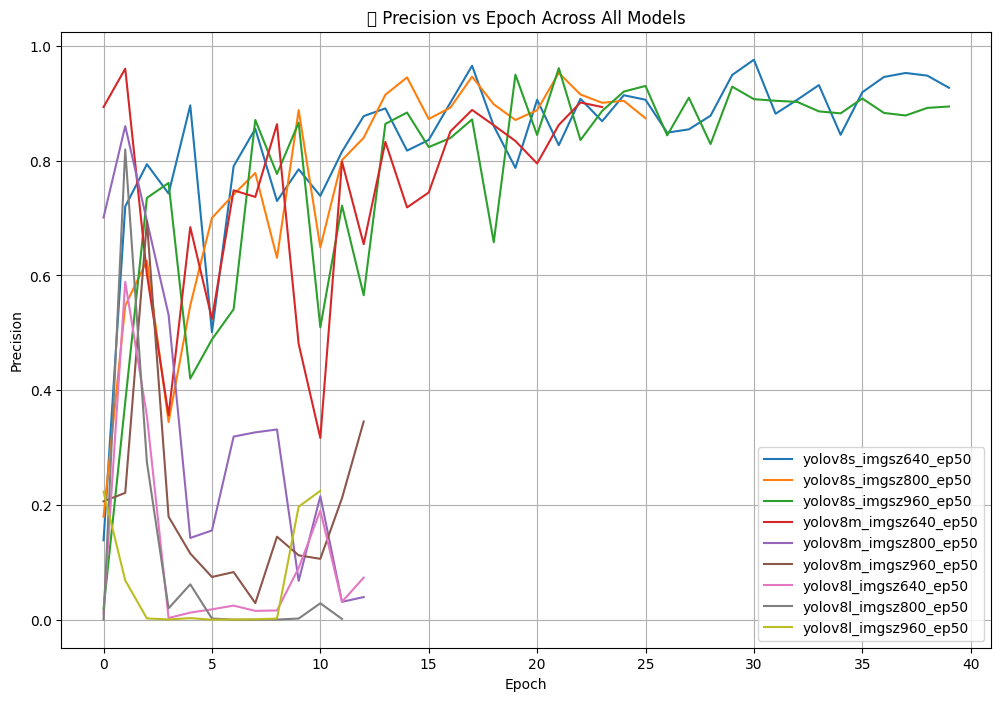


📋 Model Selection Summary (sorted by final precision):


,run_name,final_precision,final_recall
0,yolov8s_imgsz640_ep50,0.92697,0.88889
2,yolov8s_imgsz960_ep50,0.89440,0.94120
3,yolov8m_imgsz640_ep50,0.89345,0.86667
1,yolov8s_imgsz800_ep50,0.87395,0.92459
5,yolov8m_imgsz960_ep50,0.34548,0.31681
8,yolov8l_imgsz960_ep50,0.22467,0.20000
6,yolov8l_imgsz640_ep50,0.07341,0.11111
4,yolov8m_imgsz800_ep50,0.03947,0.57778
7,yolov8l_imgsz800_ep50,0.00130,0.17778


In [13]:
# ------------------ Imports ------------------
import pandas as pd
import matplotlib.pyplot as plt
import os

# ------------------ Settings ------------------
base_dir = '/content/yolo_runs'
model_types = ['yolov8s', 'yolov8m', 'yolov8l']
img_sizes = [640, 800, 960]
metric_to_plot = 'metrics/precision(B)'  # fallback to precision

summary_list = []

# ------------------ Load and Plot ------------------
fig, ax = plt.subplots(figsize=(12, 8))

for model_type in model_types:
    for imgsz in img_sizes:
        run_name = f"{model_type}_imgsz{imgsz}_ep50"
        run_path = os.path.join(base_dir, run_name)
        csv_path = os.path.join(run_path, 'results.csv')

        if not os.path.exists(csv_path):
            print(f"⚠️ Skipping {run_name}: no results.csv found.")
            continue

        df = pd.read_csv(csv_path)

        # Plot Precision Curve
        if metric_to_plot in df.columns:
            ax.plot(df.index, df[metric_to_plot], label=run_name)

        # Collect final metrics
        final_metrics = {
            'run_name': run_name,
            'final_precision': df['metrics/precision(B)'].iloc[-1] if 'metrics/precision(B)' in df else None,
            'final_recall': df['metrics/recall(B)'].iloc[-1] if 'metrics/recall(B)' in df else None
        }
        summary_list.append(final_metrics)

# Plot Settings
ax.set_xlabel('Epoch')
ax.set_ylabel('Precision')
ax.set_title('📈 Precision vs Epoch Across All Models')
ax.legend()
ax.grid(True)
plt.show()

# ------------------ Summary Table ------------------
summary_df = pd.DataFrame(summary_list)
summary_df = summary_df.sort_values(by='final_precision', ascending=False)

print("\n📋 Model Selection Summary (sorted by final precision):")
display(summary_df)


# Model Selection for Number Plate Detection

## Overview

We evaluated multiple YOLOv8 models (`s`, `m`, `l`) across three image sizes (640, 800, 960) to determine the best configuration for number plate detection. Each model was trained for 50 epochs, and the performance was assessed based on final precision and recall metrics extracted from the training logs.

## Performance Summary

- **YOLOv8s models consistently outperformed** YOLOv8m and YOLOv8l models across all image sizes.
- **Larger models** (YOLOv8m, YOLOv8l) exhibited unstable training behavior and lower precision, especially at higher resolutions, likely due to GPU memory limitations and overfitting on a relatively small dataset.
- The top two candidates were:
  - `yolov8s_imgsz640_ep50`: precision 92.7%, recall 88.9%
  - `yolov8s_imgsz960_ep50`: precision 89.4%, recall 94.1%

## Selection Criteria

For number plate detection tasks, **recall** is more critical than precision.
Missing a plate (false negatives) is worse than detecting some false positives, as plates are key targets that must not be missed. Therefore, the model with the **higher recall** while maintaining **strong precision** was preferred.

## Final Model Selected

**Model:** `yolov8s_imgsz960_ep50`

**Reason:** Achieved the highest recall (94.1%) while maintaining high precision (89.4%), providing the best balance between detection completeness and accuracy.


# Testing

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 


image 1/1 /content/plate_data/images/N1.jpeg: 544x960 2 Plates, 45.4ms
Speed: 9.8ms preprocess, 45.4ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 960)
Results saved to runs/detect/predict


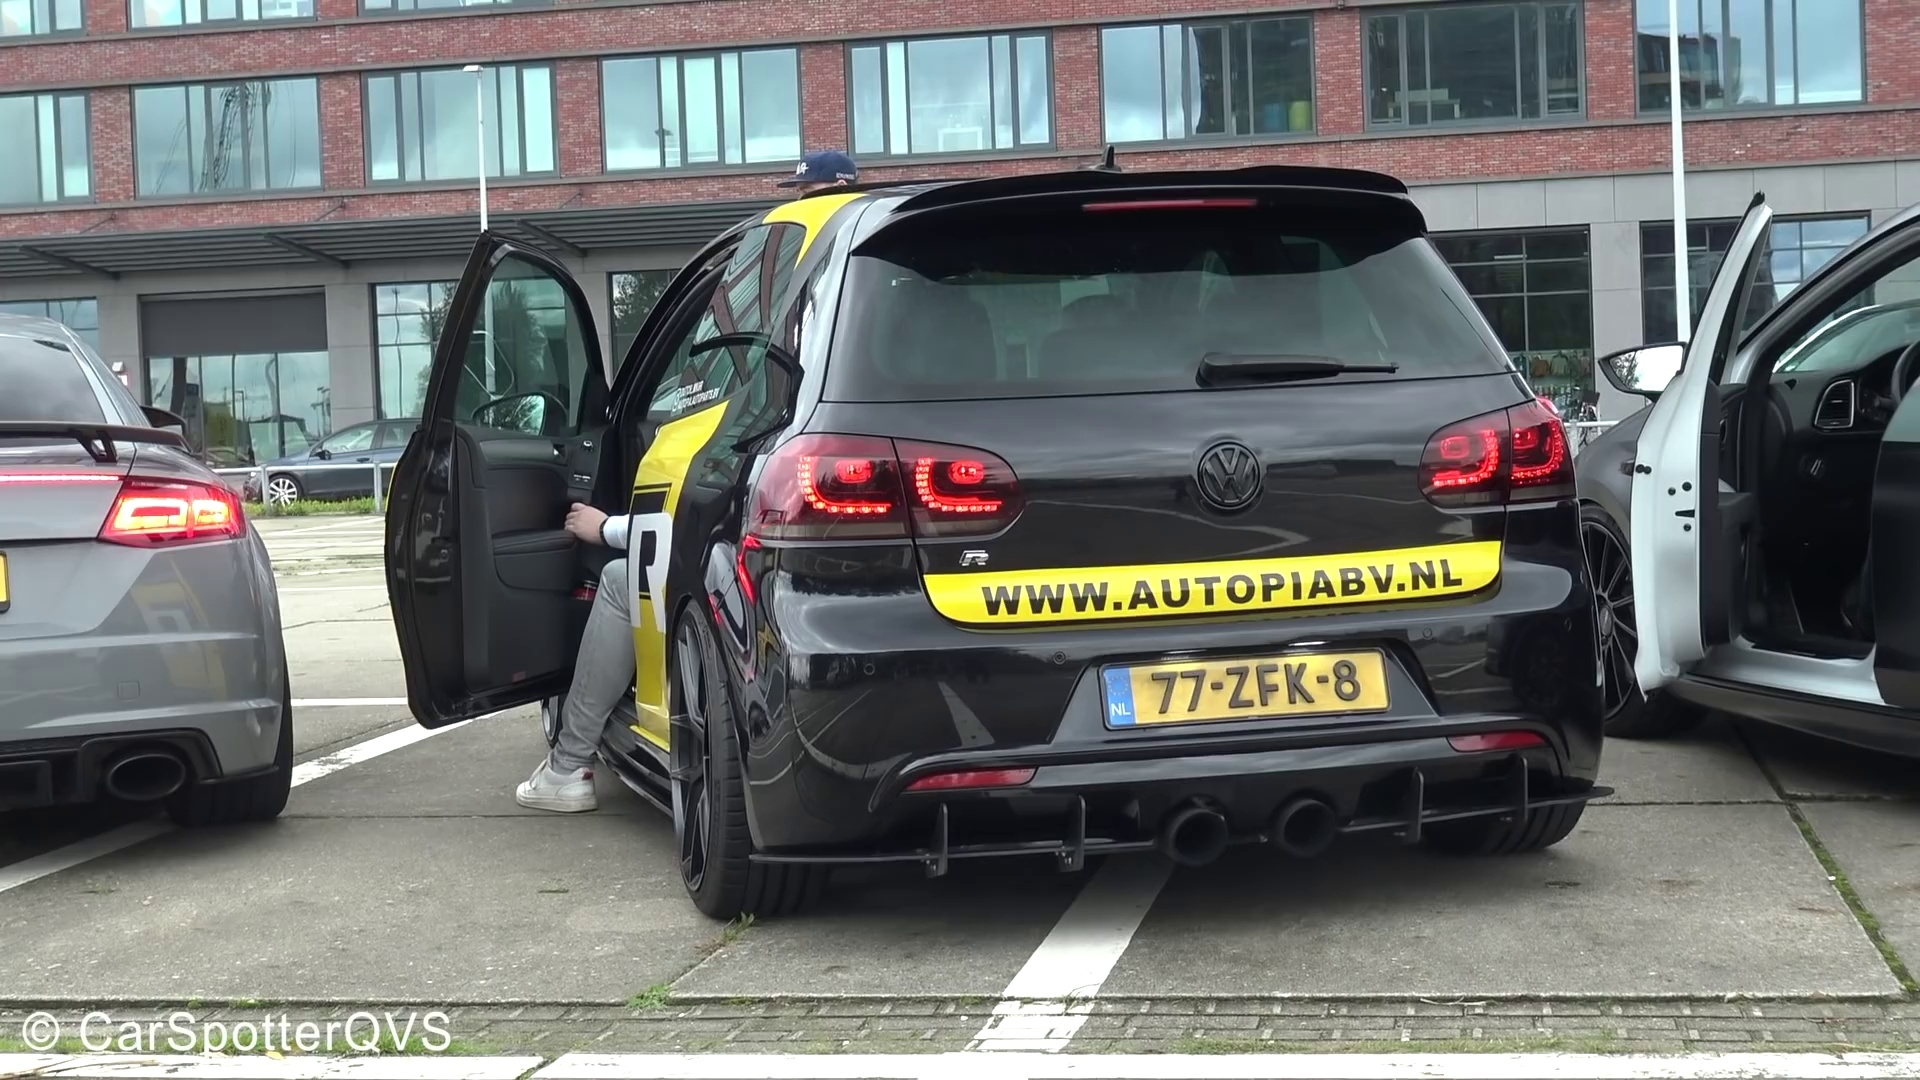

In [15]:
from ultralytics import YOLO

# Load your trained model
model_path = "/content/extracted_files/yolo/yolov8s_imgsz960_ep50/weights/best.pt"  # adjust to your best.pt path
model = YOLO(model_path)

# Predict on a new image
result = model.predict("/content/plate_data/images/N1.jpeg", save=True)

# (Optional) Show prediction
from IPython.display import Image
Image(filename='/content/plate_data/images/N1.jpeg')  # YOLO saves prediction to /runs/detect/predict/


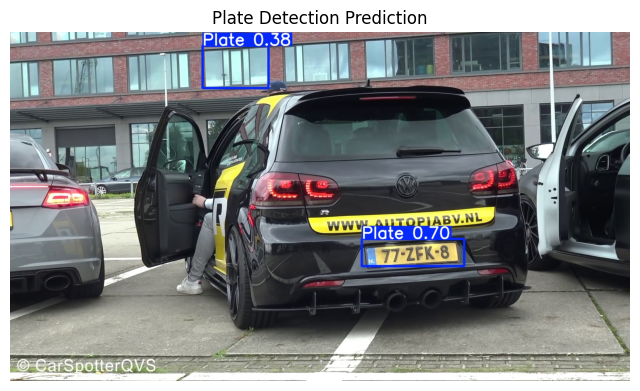

In [16]:
from PIL import Image
import matplotlib.pyplot as plt

# Load and display the result image
result_img_path = '/content/runs/detect/predict/N1.jpg'
img = Image.open(result_img_path)

plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis('off')
plt.title('Plate Detection Prediction')
plt.show()


In [19]:
# Get the first image's detection result
boxes = result[0].boxes

# If no detections
if boxes is None or boxes.cls.numel() == 0:
    print("No objects detected.")
else:
    # Convert to numpy
    class_ids = boxes.cls.cpu().numpy().astype(int)
    confidences = boxes.conf.cpu().numpy()
    bboxes = boxes.xyxy.cpu().numpy()  # (x1, y1, x2, y2) format

    # Print detections
    for cls_id, conf, bbox in zip(class_ids, confidences, bboxes):
        label = result[0].names[int(cls_id)]
        print(f"🔹 Detected {label} with confidence {conf:.2f} at {bbox}")

    # Check if Helmet is present
    if 0 in class_ids:
        print(f"\n✅ Plate detected {list(class_ids).count(0)} times!")
    else:
        print("\n❌ No Plate detected.")


🔹 Detected Plate with confidence 0.70 at [     1089.2      640.28      1406.3      724.93]
🔹 Detected Plate with confidence 0.38 at [     596.15      42.316      800.83      173.55]

✅ Plate detected 2 times!


In [18]:
result

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Plate'}
 obb: None
 orig_img: array([[[210, 214, 173],
         [215, 219, 178],
         [222, 226, 185],
         ...,
         [116, 120, 149],
         [116, 120, 149],
         [116, 120, 149]],
 
        [[209, 213, 172],
         [216, 220, 179],
         [227, 231, 190],
         ...,
         [128, 132, 161],
         [127, 131, 160],
         [126, 130, 159]],
 
        [[212, 215, 176],
         [222, 225, 186],
         [238, 241, 202],
         ...,
         [127, 129, 160],
         [125, 127, 158],
         [125, 127, 158]],
 
        ...,
 
        [[177, 203, 215],
         [173, 199, 211],
         [167, 193, 205],
         ...,
         [150, 161, 158],
         [155, 166, 163],
         [181, 192, 189]],
 
        [[121, 148, 162],
         [115, 142, 156],
         [107, 134, 148],
         ...,
         [108, 119,

## Tried With Easy OCR

In [22]:
import easyocr
import pandas as pd
import os
import cv2
import numpy as np

# Initialize OCR reader
reader = easyocr.Reader(['en'])  # English plates assumed

# Results list
results_list = []

# Load YOLO result
boxes = result[0].boxes
image = result[0].orig_img.copy()
image_path = result[0].path

# Output CSV path
csv_path = '/content/plate_results.csv'

def preprocess_plate(plate_crop):
    # Step 1: Add padding
    plate_crop = cv2.copyMakeBorder(plate_crop, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[255,255,255])

    # Step 2: Grayscale
    gray = cv2.cvtColor(plate_crop, cv2.COLOR_BGR2GRAY)

    # Step 3: Denoise
    denoised = cv2.fastNlMeansDenoising(gray, h=30)

    # Step 4: Adaptive Thresholding
    thresh = cv2.adaptiveThreshold(denoised, 255,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 21, 10)

    return thresh

if boxes is not None and boxes.cls.numel() > 0:
    class_ids = boxes.cls.cpu().numpy().astype(int)
    confidences = boxes.conf.cpu().numpy()
    bboxes = boxes.xyxy.cpu().numpy()

    for cls_id, conf, bbox in zip(class_ids, confidences, bboxes):
        label = result[0].names[int(cls_id)]

        x1, y1, x2, y2 = map(int, bbox)
        plate_crop = image[y1:y2, x1:x2]

        # Preprocess
        preprocessed_plate = preprocess_plate(plate_crop)

        # OCR original and preprocessed, take the better one
        ocr_result_raw = reader.readtext(plate_crop, detail=0)
        ocr_result_clean = reader.readtext(preprocessed_plate, detail=0)

        # Pick the one with longer string (more characters) or fallback
        plate_number_raw = ocr_result_raw[0] if ocr_result_raw else ""
        plate_number_clean = ocr_result_clean[0] if ocr_result_clean else ""

        final_plate_number = plate_number_clean if len(plate_number_clean) >= len(plate_number_raw) else plate_number_raw
        final_plate_number = final_plate_number.strip() if final_plate_number else "N/A"

        # Save
        results_list.append({
            'image_path': image_path,
            'plate_number': final_plate_number,
            'confidence': conf,
            'bbox': bbox.tolist()
        })

# Save to CSV
df_results = pd.DataFrame(results_list)
df_results.to_csv(csv_path, index=False)

print(f"✅ Saved detection + improved OCR results to {csv_path}")


✅ Saved detection + improved OCR results to /content/plate_results.csv


In [23]:
df_results.head()

,image_path,plate_number,confidence,bbox
0,/content/plate_data/images/N1.jpeg,T7ZFK-8,0.695550,"[1089.160400390625, 640.2779541015625, 1406.25..."
1,/content/plate_data/images/N1.jpeg,N/A,0.383321,"[596.14990234375, 42.316009521484375, 800.8315..."


## Tried with PaddleOCR

In [25]:
!pip install paddleocr
!pip install paddlepaddle


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.8/297.8 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 105.1 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114332 sha256=766734d91a730f251128f908e3a65d2f655e7d0bc87b6f9cbc0301109aba2ae2
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.8/192.8 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: opt_einsum
    Found existing installation: opt_einsum 3.4.0
    Uninstalling opt_einsum-3.4.0:
      

In [32]:
import cv2
import numpy as np
import pandas as pd
from paddleocr import PaddleOCR

# ------------------- PaddleOCR Init -------------------
ocr = PaddleOCR(use_angle_cls=True, lang='en', det_db_box_thresh=0.3)

# ------------------- Results list -------------------
results_list = []

# ------------------- Load YOLO Result -------------------
boxes = result[0].boxes
image = result[0].orig_img.copy()
image_path = result[0].path

# Output CSV path
csv_path = '/content/plate_results.csv'

# ------------------- Preprocessing Function -------------------
def preprocess_plate(plate_crop):
    # Step 1: Add padding
    plate_crop = cv2.copyMakeBorder(plate_crop, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[255, 255, 255])

    # Step 2: Resize to standard height
    target_height = 48
    h, w = plate_crop.shape[:2]
    scaling_factor = target_height / float(h)
    new_w = int(w * scaling_factor)
    plate_crop_resized = cv2.resize(plate_crop, (new_w, target_height), interpolation=cv2.INTER_LINEAR)

    # Step 3: Grayscale
    gray = cv2.cvtColor(plate_crop_resized, cv2.COLOR_BGR2GRAY)

    # Step 4: Contrast Stretching
    stretched = cv2.normalize(gray, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # Step 5: Reconvert to 3-channel image
    stretched_color = cv2.cvtColor(stretched, cv2.COLOR_GRAY2BGR)

    return stretched_color

# ------------------- Main Loop -------------------
if boxes is not None and boxes.cls.numel() > 0:
    class_ids = boxes.cls.cpu().numpy().astype(int)
    confidences = boxes.conf.cpu().numpy()
    bboxes = boxes.xyxy.cpu().numpy()

    for cls_id, conf, bbox in zip(class_ids, confidences, bboxes):
        label = result[0].names[int(cls_id)]

        x1, y1, x2, y2 = map(int, bbox)
        plate_crop = image[y1:y2, x1:x2]

        # Preprocess
        preprocessed_plate = preprocess_plate(plate_crop)

        # OCR both original and preprocessed
        ocr_result_raw = ocr.ocr(plate_crop, cls=True)
        ocr_result_clean = ocr.ocr(preprocessed_plate, cls=True)

        # ---------- SAFE extraction ----------
        plate_number_raw = ""
        plate_number_clean = ""

        if (ocr_result_raw is not None and isinstance(ocr_result_raw, list) and
            len(ocr_result_raw) > 0 and isinstance(ocr_result_raw[0], list) and
            len(ocr_result_raw[0]) > 0):
            plate_number_raw = ocr_result_raw[0][0][1][0]

        if (ocr_result_clean is not None and isinstance(ocr_result_clean, list) and
            len(ocr_result_clean) > 0 and isinstance(ocr_result_clean[0], list) and
            len(ocr_result_clean[0]) > 0):
            plate_number_clean = ocr_result_clean[0][0][1][0]

        # Pick the better one
        final_plate_number = plate_number_clean if len(plate_number_clean) >= len(plate_number_raw) else plate_number_raw
        final_plate_number = final_plate_number.strip() if final_plate_number else "N/A"

        # Save
        results_list.append({
            'image_path': image_path,
            'plate_number': final_plate_number,
            'confidence': float(conf),
            'bbox': bbox.tolist()
        })

# ------------------- Save to CSV -------------------
df_results = pd.DataFrame(results_list)
df_results.to_csv(csv_path, index=False)

print(f"✅ Saved detection + PaddleOCR results to {csv_path}")


[2025/04/28 18:46:49] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.3, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_l

In [33]:
df_results.head()

,image_path,plate_number,confidence,bbox
0,/content/plate_data/images/N1.jpeg,77-ZFK-8,0.695550,"[1089.160400390625, 640.2779541015625, 1406.25..."
1,/content/plate_data/images/N1.jpeg,N/A,0.383321,"[596.14990234375, 42.316009521484375, 800.8315..."
